<a href="https://colab.research.google.com/github/tianiayu/UAS-Data-Science/blob/main/UAS_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=37a42248c507e71d6e6d8e3872a4703b1ff3e26994d921e14a459b8552e368e1
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
# Import library yang diperlukan
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import *

In [3]:
# Inisialisasi SparkSession
spark = SparkSession.builder.appName('SahamPrediction').getOrCreate()

In [4]:
# Definisikan schema kolom-kolom dengan tipe data yang sesuai
schema = StructType([
    StructField("Date", StringType(), True),
    StructField("Open", DoubleType(), True),
    StructField("High", DoubleType(), True),
    StructField("Low", DoubleType(), True),
    StructField("Close", DoubleType(), True),
    StructField("Adj Close", FloatType(), True),
    StructField("Volume", DoubleType(), True),
    # Tambahkan kolom lain sesuai kebutuhan dan jenis datanya
])

In [6]:
# Memuat data dari file CSV (contoh)
df = spark.read.csv("BNGA.JK.csv", header=True, schema=schema)
df.show()

+----------+------+------+------+------+---------+---------+
|      Date|  Open|  High|   Low| Close|Adj Close|   Volume|
+----------+------+------+------+------+---------+---------+
|2019-01-01| 915.0| 915.0| 915.0| 915.0|662.80994|      0.0|
|2019-01-02| 925.0| 975.0| 915.0| 970.0|  702.651|2.31965E7|
|2019-01-03| 970.0|1075.0| 970.0|1055.0| 764.2235|4.26508E7|
|2019-01-04|1060.0|1075.0|1025.0|1055.0| 764.2235|1.08759E7|
|2019-01-07|1055.0|1145.0|1055.0|1115.0| 807.6864|2.51286E7|
|2019-01-08|1125.0|1130.0|1090.0|1100.0|796.82074|6791100.0|
|2019-01-09|1100.0|1115.0|1095.0|1095.0|793.19885|5389300.0|
|2019-01-10|1095.0|1115.0|1045.0|1105.0| 800.4426|1.19134E7|
|2019-01-11|1105.0|1150.0|1105.0|1125.0|814.93036|1.25613E7|
|2019-01-14|1125.0|1135.0|1090.0|1100.0|796.82074|6973600.0|
|2019-01-15|1100.0|1135.0|1095.0|1130.0|818.55225|5833400.0|
|2019-01-16|1130.0|1140.0|1110.0|1120.0|811.30835|5741300.0|
|2019-01-17|1125.0|1140.0|1095.0|1095.0|793.19885|6246500.0|
|2019-01-18|1110.0|1115.

In [7]:
# Menampilkan skema DataFrame
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- Volume: double (nullable = true)



In [8]:
#describe with specific variables
df.describe(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']).show()

+-------+------------------+------------------+------------------+------------------+-----------------+-------------------+
|summary|              Open|              High|               Low|             Close|        Adj Close|             Volume|
+-------+------------------+------------------+------------------+------------------+-----------------+-------------------+
|  count|              1231|              1231|              1231|              1231|             1231|               1231|
|   mean|1081.4622258326565|1096.4662875710803|1067.3639317627944|1080.6661251015435|926.1658641031174|  7233682.615759545|
| stddev| 259.0825244323926| 260.1461102136569| 258.4851444184299| 259.8772439688772|315.4253648600656|1.025783196643582E7|
|    min|             540.0|             575.0|             515.0|             550.0|          408.889|                0.0|
|    max|            1790.0|            1815.0|            1770.0|            1790.0|           1790.0|         1.511562E8|
+-------

In [9]:
# Menghapus baris yang memiliki nilai null di kolom-kolom tertentu
df_cleaned = df.na.drop(subset=["Open", "High", "Low", "Close", "Adj Close", "Volume"])

In [10]:
# Memilih fitur yang akan digunakan untuk prediksi (misalnya: 'Open', 'High', 'Low', 'Volume')
feature_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Membuat assembler untuk menggabungkan fitur-fitur menjadi satu kolom "features"
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Transformasi data menggunakan VectorAssembler
data = assembler.transform(df_cleaned)

In [11]:
# Memisahkan data menjadi set pelatihan (70%) dan set pengujian (30%)
train_data, test_data = data.randomSplit([0.7, 0.3])

In [12]:
# Inisialisasi model Decision Tree
dt = DecisionTreeRegressor(featuresCol='features', labelCol='Close')

# Melatih model Decision Tree
dt_model = dt.fit(train_data)

In [13]:
# Inisialisasi model Random Forest
rf = RandomForestRegressor(featuresCol='features', labelCol='Close')

# Melatih model Random Forest
rf_model = rf.fit(train_data)

In [14]:
# Evaluasi performa model Decision Tree pada data pengujian
dt_predictions = dt_model.transform(test_data)
dt_evaluator = RegressionEvaluator(labelCol='Close', metricName='rmse')
dt_rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (Decision Tree):", dt_rmse)

Root Mean Squared Error (Decision Tree): 19.07783220809059


In [15]:
# Evaluasi performa model Random Forest pada data pengujian
rf_predictions = rf_model.transform(test_data)
rf_evaluator = RegressionEvaluator(labelCol='Close', metricName='rmse')
rf_rmse = rf_evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (Random Forest):", rf_rmse)

Root Mean Squared Error (Random Forest): 16.456338280164854


In [16]:
from pyspark.ml.evaluation import RegressionEvaluator

# Melakukan prediksi dengan model yang telah dilatih sebelumnya (misalnya model rf_model)
predictions = rf_model.transform(test_data)

# Membuat evaluator untuk R-squared
evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="r2")

# Menghitung R-squared
r2 = evaluator.evaluate(predictions)
print("R-squared:", r2)


R-squared: 0.9960837448384626


In [17]:
from pyspark.sql.functions import col

# Evaluasi performa model Decision Tree pada data pengujian
dt_predictions = dt_model.transform(test_data)

# Menghitung deviasi antara prediksi dan harga saham aktual
dt_predictions = dt_predictions.withColumn("Deviation", (col("prediction") - col("Close")) / col("Close"))

# Menghitung akurasi relatif dalam bentuk persentase
accuracy_percentage = (1 - dt_predictions.select("Deviation").agg({"Deviation": "mean"}).collect()[0][0]) * 100
print(f"Akurasi Relatif Model Decision Tree: {accuracy_percentage:.2f}%")


Akurasi Relatif Model Decision Tree: 99.98%


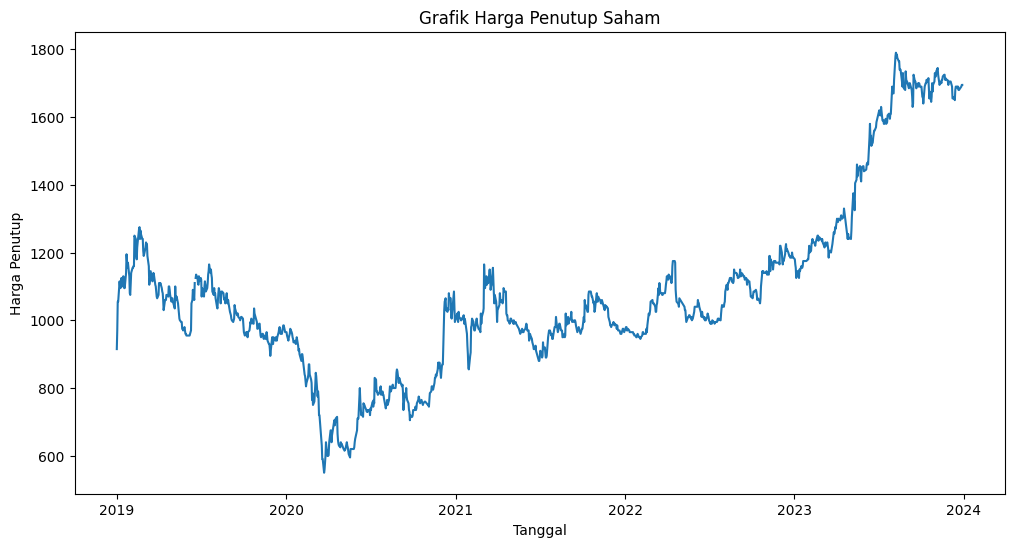

In [20]:
# Visualisasi candlestick chart menggunakan PySpark DataFrame
df = df.withColumn("Date", col("Date").cast("date"))
df_pd = df.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(df_pd['Date'], df_pd['Close'])
plt.title('Grafik Harga Penutup Saham')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutup')
plt.show()

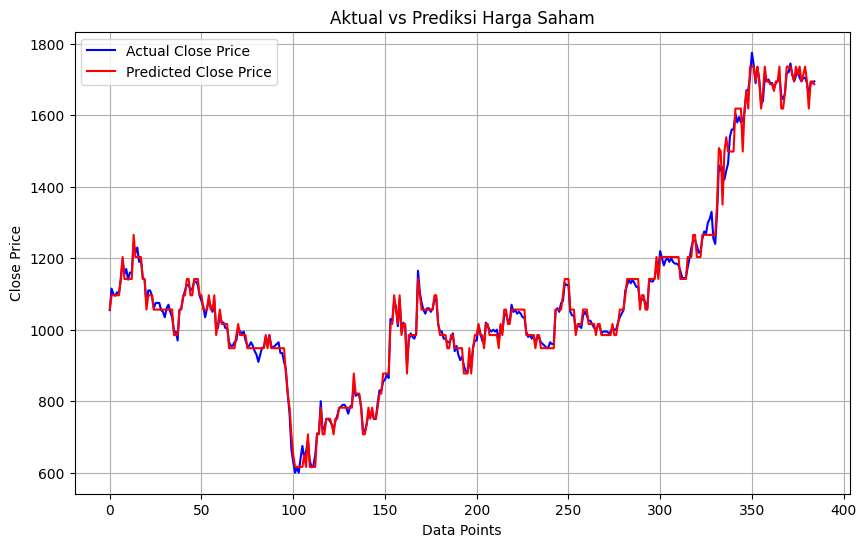

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Konversi hasil prediksi menjadi DataFrame Pandas
dt_pred_pd = dt_predictions.select("Close", "prediction","Date").toPandas()

# Mengurutkan berdasarkan tanggal jika diperlukan
#dt_pred_pd.sort_values(by='Date', inplace=True)

# Plot harga saham aktual dan prediksi
plt.figure(figsize=(10, 6))
plt.plot(dt_pred_pd['Close'], label='Actual Close Price', color='blue')
plt.plot(dt_pred_pd['prediction'], label='Predicted Close Price', color='red')

plt.title('Aktual vs Prediksi Harga Saham')
plt.xlabel('Data Points')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()